In [1]:
import pandas as pd
import requests
import configparser
import json
import matplotlib.pyplot as plt
import folium

In [2]:
from datetime import datetime, timezone, timedelta
gmt_plus_5_30 = timezone(timedelta(hours=5, minutes=30))

current_time = datetime.now(gmt_plus_5_30).strftime("%Y-%m-%d | %H:%M:%S")
current_time

'2024-12-09 | 17:49:02'

## Load the API keys

In [10]:
!wget "https://raw.githubusercontent.com/kavyajeetbora/airflow_streamlit_orchestration/refs/heads/master/config/data/weather.csv" -O weather.csv

--2024-12-09 12:22:19--  https://raw.githubusercontent.com/kavyajeetbora/airflow_streamlit_orchestration/refs/heads/master/config/data/weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1613 (1.6K) [text/plain]
Saving to: ‘weather.csv’

weather.csv         100%[===================>]   1.58K  --.-KB/s    in 0s      

2024-12-09 12:22:19 (4.61 MB/s) - ‘weather.csv’ saved [1613/1613]



In [14]:
df = pd.read_csv('weather.csv')
df = df.sort_values(by='feels_like')
df.head()

,Unnamed: 0,City,Latitude,Longitude,temp,feels_like,temp_min,temp_max,pressure,humidity,sea_level,grnd_level
15,15,Bhopal,23.2599,77.4126,18.32,17.12,18.32,18.32,1015.0,35.0,1015.0,958.0
11,11,Kanpur,26.4499,80.3319,20.21,19.28,20.21,20.21,1014.0,38.0,1014.0,999.0
13,13,Indore,22.7196,75.8577,20.09,19.43,20.09,20.09,1015.0,49.0,1015.0,952.0
1,1,Delhi,28.7041,77.1025,20.06,19.69,20.06,20.06,1014.0,60.0,1014.0,989.0
10,10,Lucknow,26.8467,80.9462,20.73,19.85,20.73,20.73,1014.0,38.0,1014.0,1000.0


## Plot the weather data

In [15]:
def plot_city_temperatures(df):
    """
    Plots the temperature of cities from the given DataFrame.

    df (DataFrame): DataFrame containing city names and their corresponding temperatures.
    """
    fig, ax = plt.subplots(figsize=(12, 6))  # Create a figure and axis

    # Create a bar graph
    bars = ax.bar(df['City'], df['temp'], color='skyblue')

    # Add titles and labels
    ax.set_title('Temperature of Cities in India', fontsize=16)
    ax.set_xlabel('City', fontsize=14)
    ax.set_ylabel('Temperature (°C)', fontsize=14)

    # Rotate x-titles for better visibility
    ax.set_xticks(range(len(df['City'])))  # Set x-ticks to match the number of cities
    ax.set_xticklabels(df['City'], rotation=45, ha='right')

    # Add grid for better readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()  # Get the height of the bar
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}',
                ha='center', va='bottom', fontsize=10)  # Add text above the bar

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    # Show the plot
    plt.show()

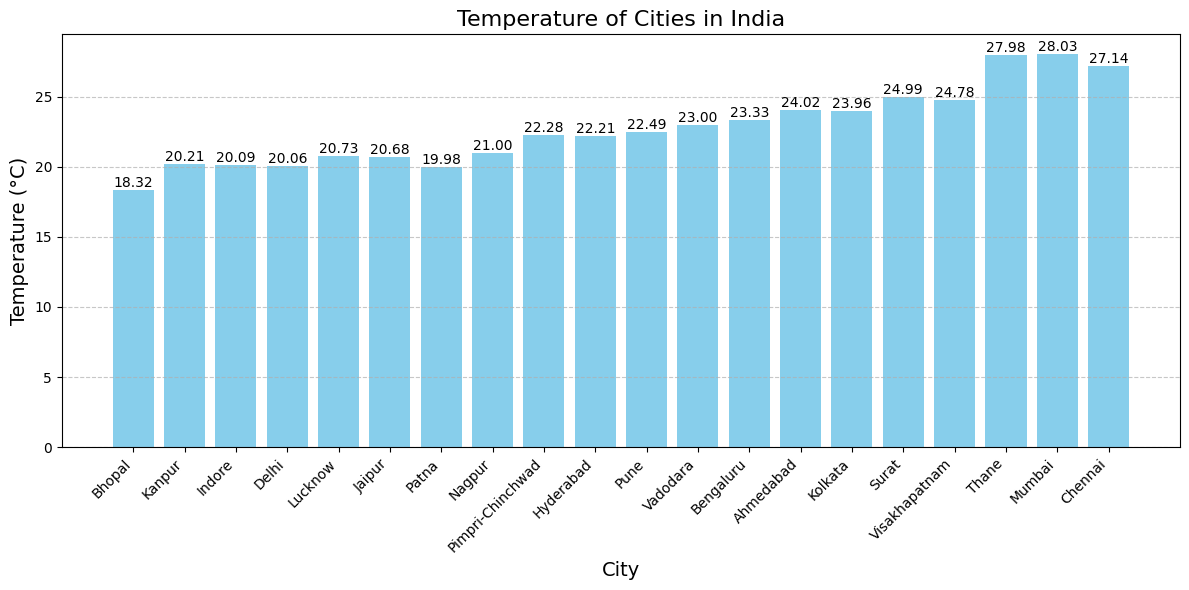

In [16]:
plot_city_temperatures(df)

## Plot it in folium map


In [18]:
def plot_city_on_map(df):
    """
    Plots cities on a Folium map with markers displaying city name and temperature when clicked.
    """

    # Create a map centered around India
    m = folium.Map(location=[20.5937, 78.9629], zoom_start=4)  # Adjust coordinates and zoom as needed

    for index, row in df.iterrows():
        city = row['City']
        lat = row['Latitude']
        lon = row['Longitude']
        temp = row['temp']

        # Create a marker for each city
        folium.Marker(
            location=[lat, lon],
            popup=f"<b>City:</b> {city}<br><b>Temperature:</b> {temp}°C",  # HTML for popup content
            tooltip=city,  # Display city name on hover
        ).add_to(m)

    # Display the map
    return m

# Assuming 'df' is already loaded from the previous code cells
m = plot_city_on_map(df)
m

In [21]:
# prompt: Ok can we color the placemarker depending on the value of the temp? take relative color coding and divide the colors into 5 bins, say take max and min temp values from all the cities. Can we display the temperate and city name directly instead of clicking and display as in the tooltip

import pandas as pd
import requests
import configparser
import json
import matplotlib.pyplot as plt
import folium
from datetime import datetime, timezone, timedelta
from branca.colormap import LinearColormap

gmt_plus_5_30 = timezone(timedelta(hours=5, minutes=30))

current_time = datetime.now(gmt_plus_5_30).strftime("%Y-%m-%d | %H:%M:%S")
current_time

# Load the API keys
!wget "https://raw.githubusercontent.com/kavyajeetbora/airflow_streamlit_orchestration/refs/heads/master/config/data/weather.csv" -O weather.csv
df = pd.read_csv('weather.csv')
df = df.sort_values(by='feels_like')







def plot_city_on_map(df):
    """
    Plots cities on a Folium map with markers displaying city name and temperature.
    """
    # Calculate min and max temperatures
    min_temp = df['temp'].min()
    max_temp = df['temp'].max()

    # Create a colormap
    colormap = LinearColormap(['blue', 'green', 'yellow', 'orange', 'red'], vmin=min_temp, vmax=max_temp)

    m = folium.Map(location=[20.5937, 78.9629], zoom_start=4)

    for index, row in df.iterrows():
        city = row['City']
        lat = row['Latitude']
        lon = row['Longitude']
        temp = row['temp']

        # Determine color based on temperature
        color = colormap(temp)

        folium.CircleMarker(
            location=[lat, lon],
            radius=8,
            color=color,  # Set marker color
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"<b>City:</b> {city}<br><b>Temperature:</b> {temp}°C",
            tooltip=f"{city}: {temp}°C"  # Display city and temperature on hover
        ).add_to(m)

    m.add_child(colormap) #add colormap to the map
    return m

# Assuming 'df' is already loaded from the previous code cells
m = plot_city_on_map(df)
m

--2024-12-09 12:29:34--  https://raw.githubusercontent.com/kavyajeetbora/airflow_streamlit_orchestration/refs/heads/master/config/data/weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1613 (1.6K) [text/plain]
Saving to: ‘weather.csv’

weather.csv         100%[===================>]   1.58K  --.-KB/s    in 0s      

2024-12-09 12:29:34 (21.1 MB/s) - ‘weather.csv’ saved [1613/1613]

